# Les imports

In [1]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.isotonic import IsotonicRegression

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
torch.cuda.is_available()

False

check GPU stats :

In [3]:
!nvidia-smi

'nvidia-smi' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


# Los geht's !

### Definition des classes d'objets

#### Classe de nos datas

In [4]:
class GeoEye1(Dataset):

    # mapping between label class names and indices
    LABEL_CLASSES = {
        'no_damage': 0,
        'damage': 1,
    }

    def __init__(self, root_dir="ipeo_hurricane_for_students", split='train', transforms=None):
        self.transforms = transforms

        # Chemin du dossier correspondant au split (train/test/validation)
        split_dir = os.path.join(root_dir, split)

        # Liste qui contiendra (chemin_image, label)
        self.data = []

        # Pour chaque classe (damage / no_damage)
        for class_name, class_idx in self.LABEL_CLASSES.items():
            class_dir = os.path.join(split_dir, class_name)

            if not os.path.isdir(class_dir):
                continue

            # Récupération de toutes les images du dossier
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(".jpeg"):
                    img_path = os.path.join(class_dir, img_name)
                    self.data.append((img_path, class_idx))

        # Optionnel: trier pour reproductibilité
        self.data.sort()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)

        return img, label


##### Calculs préliminaires de la mean et std des train data

In [5]:
# Dataset sans augmentation et sans Normalize pour calculer mean/std
transforms_for_stats = T.Compose([
    T.Resize((150, 150)),
    T.ToTensor()
])

train_dataset_raw = GeoEye1(
    root_dir="ipeo_hurricane_for_students",
    split="train",
    transforms=transforms_for_stats
)

loader = DataLoader(train_dataset_raw, batch_size=56, shuffle=False, num_workers=4)

In [6]:
# Compute mean & std
mean = 0.
std = 0.
total_images = 0

for imgs, _ in loader:
    batch_size = imgs.size(0)
    imgs = imgs.view(batch_size, imgs.size(1), -1)
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    total_images += batch_size

mean /= total_images
std /= total_images

print("Mean =", mean)
print("Std  =", std)


ZeroDivisionError: float division by zero

avec images 224*224:\
Mean = tensor([0.3521, 0.3835, 0.2852])\
Std  = tensor([0.1132, 0.0980, 0.0992])

avec images 150*150:\
Mean = tensor([0.3518, 0.3832, 0.2850])
Std  = tensor([0.1127, 0.0974, 0.0986])

#### preprocess des images, data augmentation...

In [ ]:
normalize = T.Normalize(mean, std)

std_inv = 1 / (std + 1e-7)
unnormalize = T.Normalize(-mean * std_inv, std_inv)

transforms_train = T.Compose([
  T.RandomResizedCrop(size=(150, 150), antialias=True),
  T.RandomHorizontalFlip(p=0.1),
  T.RandomVerticalFlip(p=0.1),
  T.RandomPosterize(bits=6, p=0.1),
  T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5 , hue=0.3),
  #T.RandomAffine(degrees=(0, 180), translate=None, scale=None, shear=None, interpolation='nearest', fill=0),

  T.Resize((150, 150)),
  T.ToTensor(),
  normalize
])

transforms_val = T.Compose([
  T.Resize((150, 150)),
  T.ToTensor(),
  normalize
])


#### Visualiser quelques images du dataset

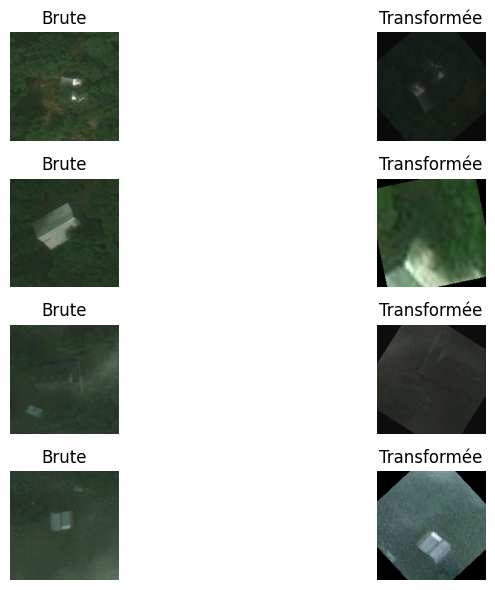

In [11]:
# dataset original (sans augmentations)
raw_ds = GeoEye1("ipeo_hurricane_for_students", "train",
                 transforms=T.Compose([T.Resize((150,150)), T.ToTensor()]))

# dataset avec augmentations
aug_ds = GeoEye1("ipeo_hurricane_for_students", "train",
                 transforms=transforms_train)

def show_tensor_image(t):
    img = t.clamp(0,1).permute(1,2,0).cpu().numpy()
    plt.imshow(img)
    plt.axis("off")

plt.figure(figsize=(10,6))
for i in range(4):
    raw_img, _ = raw_ds[i]
    aug_img, _ = aug_ds[i]

    plt.subplot(4,2,2*i+1)
    plt.title("Brute")
    show_tensor_image(raw_img)

    plt.subplot(4,2,2*i+2)
    plt.title("Transformée")
    show_tensor_image(unnormalize(aug_img))

plt.tight_layout()
plt.show()

a `torch.utils.data.DataLoader` is a wrapper around a `torch.utils.data.Dataset` class that allows us to load multiple images in a batch **in parallel** (on CPU and RAM) which speeds up the training by loading data faster.

In [ ]:
class LightningClassifierModelWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(1) == y).float().mean()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        return y_hat, y

    def configure_optimizers(self):
        # return torch.optim.Adam(self.parameters(), lr=0.01, momentum=0.9)
        return torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)

### Instanciation des objets

In [ ]:
train_dataset = GeoEye1("ipeo_hurricane_for_students", "train", transforms_train)
val_dataset = GeoEye1("ipeo_hurricane_for_students", "validation", transforms_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

ResNet18

In [ ]:
# toujours de l'instanciation des objet...
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
#model = torchvision.models.alexnet(weights="IMAGENET1K_V1")
#model = DEFINIR NOTRE PROPRE MODELE
model.fc = torch.nn.Linear(model.fc.in_features, 2)

lightning_model = LightningClassifierModelWrapper(model)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=pl.loggers.TensorBoardLogger("logs/", name="hurricane"),
    callbacks=[
        ModelCheckpoint(
            dirpath="checkpoints",
            filename="resnet18-{epoch}-{val_accuracy:.2f}",
            monitor="val_accuracy",
            mode="max"
        )
    ]
)

'model = torchvision.models.resnet18(num_classes=2)\npytorch_lightning_model = LightningClassifierModelWrapper(model)\n\ntb_logger = pl_loggers.TensorBoardLogger(save_dir="logs/", name="experimentname")\n\ncheckpoint_callback = ModelCheckpoint(\n    dirpath=\'checkpoints\',\n    filename=\'alexnet-{epoch}-{val_accuracy:.2f}\',\n    monitor="val_accuracy",\n    mode="max"\n    )\n\ntrainer = pl.Trainer(max_epochs=100, accelerator="cpu", devices=1,        # replace by accelerator="gpu", devices=[0]\n                     logger=tb_logger, callbacks=[checkpoint_callback])'

### Appel des fonctions

In [ ]:
trainer.fit(lightning_model, train_loader, val_loader)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
!ls checkpoints

In [ ]:
test_dataset = GeoEye1(transforms = transforms_val, split="test")
test_dl = DataLoader(test_dataset, batch_size = 16)

# TODO: replace with the checkpoint of your trained model
checkpoint_path = "checkpoints/resnet18-epoch=3-val_accuracy=0.92.ckpt"
#checkpoint_path = "checkpoints/alexnet-epoch=48-val_accuracy=0.70.ckpt"

rs = trainer.predict(lightning_model, dataloaders=test_dl,
                ckpt_path=checkpoint_path)

y_hat, y = list(map(list, zip(*rs)))
y_hat = torch.vstack(y_hat)
y = torch.hstack(y)
accuracy = (y_hat.argmax(1) == y).float().mean()
print(f"test accuracy {accuracy:.4f}")

## Model Calibration


In [ ]:



class IsotonicCalibration:
    """
    Isotonic Regression pour calibrer les probabilités du modèle
    """
    def __init__(self):
        self.iso_reg = IsotonicRegression(y_min=0,y_max=1,out_of_bounds='clip')
    
    def fit(self, logits, labels):
        """
        Entraîne le modèle de calibration sur le validation set
        """
        # Convertir logits en probabilités
        probs = F.softmax(logits, dim=1)
        
        # Prendre la probabilité de la classe prédite
        confidences = torch.max(probs, dim=1)[0].numpy()
        
        # Créer des targets binaires (1 si prédiction correcte, 0 sinon)
        predictions = torch.argmax(probs, dim=1)
        correct = (predictions == labels).float().numpy()
        
        # Fit isotonic regression
        self.iso_reg.fit(confidences, correct)
        return self
    
    def predict(self, logits):
        """
        Retourne les probabilités calibrées
        """
        probs = F.softmax(logits, dim=1).numpy()
        
        # Calibrer chaque probabilité
        calibrated_probs = np.zeros_like(probs)
        for i in range(probs.shape[0]):
            for j in range(probs.shape[1]):
                calibrated_probs[i, j] = self.iso_reg.predict([probs[i, j]])[0]
        
        # Normaliser pour que la somme = 1
        calibrated_probs = calibrated_probs / calibrated_probs.sum(axis=1, keepdims=True)
        
        return torch.from_numpy(calibrated_probs).float()

def compute_ece(probs, labels, n_bins=15):
    """
    Expected Calibration Error
    Mesure la différence entre confiance et précision
    """
    confidences, predictions = torch.max(probs, 1)
    accuracies = predictions.eq(labels)
    
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    ece = torch.zeros(1)
    
    for bin_lower, bin_upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece.item()

def collect_logits_and_labels(model, dataloader, device):
    """
    Collecte tous les logits et labels du validation set
    """
    model.eval()
    all_logits = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            logits = model(images)
            all_logits.append(logits.cpu())
            all_labels.append(labels)
    
    return torch.cat(all_logits), torch.cat(all_labels)

In [ ]:
# Utilisation de la calibration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lightning_model.to(device)

# 1. Collecter les logits sur le validation set
print("Collecte des logits...")
val_logits, val_labels = collect_logits_and_labels(
    lightning_model.model, 
    val_loader, 
    device
)

# 2. Calculer l'ECE avant calibration
nb_bins = 15
probs_before = F.softmax(val_logits, dim=1)
ece_before = compute_ece(probs_before, val_labels, n_bins=nb_bins)
print(f"ECE avant calibration: {ece_before:.4f}")

# 3. Entraîner le modèle de calibration
print("\nCalibration du modèle...")
Iso_cal = IsotonicCalibration()
Iso_cal.fit(val_logits, val_labels)
print(f"Calibration terminée")

# 4. Calculer l'ECE après calibration
calibrated_logits = Iso_cal(val_logits)
probs_after = F.softmax(calibrated_logits, dim=1)
ece_after = compute_ece(probs_after, val_labels)
print(f"ECE après calibration: {ece_after:.4f}")

# 5. Visualiser la calibration
def plot_reliability_diagram(probs, labels, n_bins=10, title=""):
    confidences, predictions = torch.max(probs, 1)
    accuracies = predictions.eq(labels)
    
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    accuracies_in_bins = []
    confidences_in_bins = []
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        
        if prop_in_bin.item() > 0:
            accuracies_in_bins.append(accuracies[in_bin].float().mean().item())
            confidences_in_bins.append(confidences[in_bin].mean().item())
    
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    plt.plot(confidences_in_bins, accuracies_in_bins, 's-', label='Model')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Avant et après calibration
plot_reliability_diagram(probs_before, val_labels, title="Avant calibration")
plot_reliability_diagram(probs_after, val_labels, title="Après calibration")
